Imports and installations

In [ ]:
#necessary downloads

!apt install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8
!pip install -U tensorflow_text tensorflow tensorflow_datasets
!pip install einops
#!pip uninstall -y tensorflow estimator keras

In [2]:
#necessary imports

import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request
import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm
from google.colab import files

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

Data importing and preprocessing

In [3]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)

  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

In [4]:
#Loading our dataset
train_raw, test_raw = flickr8k()


2340801/2340801 [==============================] - 0s 0us/step


### Image feature extractor Mobilenet



In [10]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

Text tokenizer

In [12]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [13]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [14]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [17]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

### Prepare our datasets

In [20]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [21]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain `(inputs, labels)` pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an `(images, texts)` pair to an `((images, input_tokens), label_tokens)` pair:

In [22]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the `image, caption` pairs.
4. Tokenize the text, shift the tokens and add `label_tokens`.
5. Convert the text from a `RaggedTensor` representation to padded dense `Tensor` representation.

In [23]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [24]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [25]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### Cache the image features

In [26]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU.
  def gen():
    for (images, captions) in tqdm.tqdm(ds):
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)

  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [27]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

188it [02:42,  1.16it/s]
32it [00:41,  1.29s/it]


 </section>


## Data ready for training

After those preprocessing steps, here are the datasets:

In [28]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [29]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns `(input, label)` pairs suitable for training with keras. The `inputs` are `(images, input_tokens)` pairs. The `images` have been processed with the feature-extractor model. For each location in the `input_tokens` the model looks at the text so far and tries to predict the next which is lined up at the same location in the `labels`.

In [45]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 23)
(32, 23)


The input tokens and the labels are the same, just shifted by 1 step:

In [46]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3  185    8   29  273   12   49    7    6  276   13    2  394 3139
   22    2   97    0    0    0    0    0    0]
[ 185    8   29  273   12   49    7    6  276   13    2  394 3139   22
    2   97    4    0    0    0    0    0    0]


In [47]:
train_ds.take(1)

<_TakeDataset element_spec=((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

## A Transformer decoder model



<table>

<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png"/>
  </td>
</tr>
</table>

The model will be implemented in three main parts:

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

In [48]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)

    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder

In [49]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


The `CrossAttention` layer is below. Note the use of `return_attention_scores`.

In [50]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)

    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [51]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger `DecoderLayer`. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for later visualizations.

In [52]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output


1. **Handle bad tokens**:

2. **Smart initialization**:

In [53]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()

    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


The smart initialization will significantly reduce the initial loss:

In [54]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 938/938 [00:17<00:00, 52.35it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [55]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True)

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [56]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)

    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    txt = self.output_layer(txt)

    return txt

In [57]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [58]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence)

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

## Train

### Losses and metrics

Here's an implementation of a masked loss and accuracy:

When calculating the mask for the loss, note the `loss < 1e8`. This term discards the artificial, impossibly high losses for the `banned_tokens`.

In [60]:
def masked_loss(labels, preds):
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8)
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

For feedback during training setup a `keras.callbacks.Callback` to generate some captions for the surfer image at the end of each epoch.

In [68]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    #image_url = 'https://images.pexels.com/photos/7092613/pexels-photo-7092613.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1'
    image_path = "/content/Profteachingexample.jpg"
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [70]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=3, restore_best_weights=True)]

### Train

Configure and execute the training.

In [71]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [72]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.0138 - masked_acc: 0.2003

a man in a a man in a
a man in a woman a red in a man
two purple in the with and teammates stand

100/100 [==============================] - 83s 738ms/step - loss: 5.0138 - masked_acc: 0.2003 - val_loss: 4.7083 - val_masked_acc: 0.2366
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.6523 - masked_acc: 0.2535

a man in a red and a red
a man is is of a rock
van man climbs a green handicapped the women

100/100 [==============================] - 70s 696ms/step - loss: 4.6523 - masked_acc: 0.2535 - val_loss: 4.4058 - val_masked_acc: 0.2643
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.4321 - masked_acc: 0.2752

a man in a red and a red and a man
a woman and a large shirt and a blue
a puppies outstretched kayaking shaking object and glacier dressed with two

100/100 [==============================] - 76s 765ms/step - loss: 4.4321 - masked_ac

Plot the loss and accuracy over the training run:

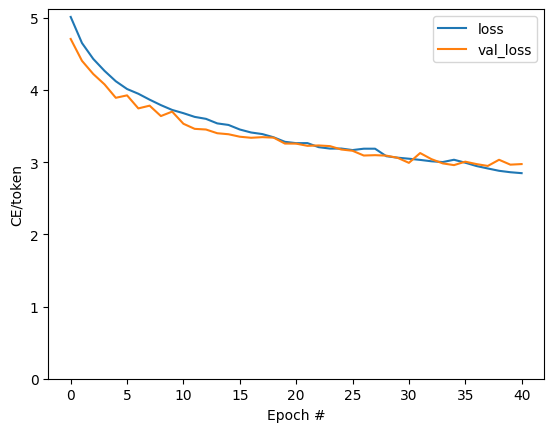

In [73]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

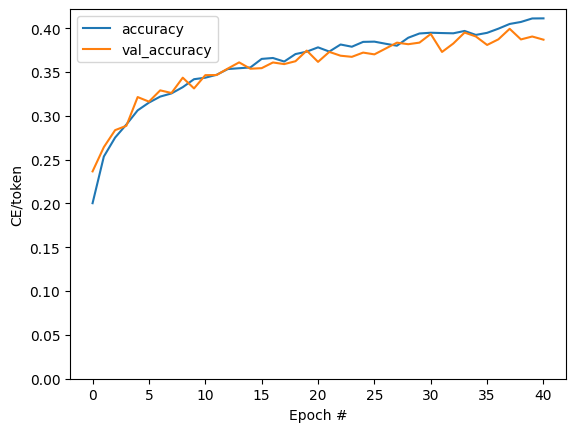

In [74]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

In [98]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')

  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  print(result_txt)
  t.set_y(1.05)


a man in a black shirt and white shirt is standing on a white bench


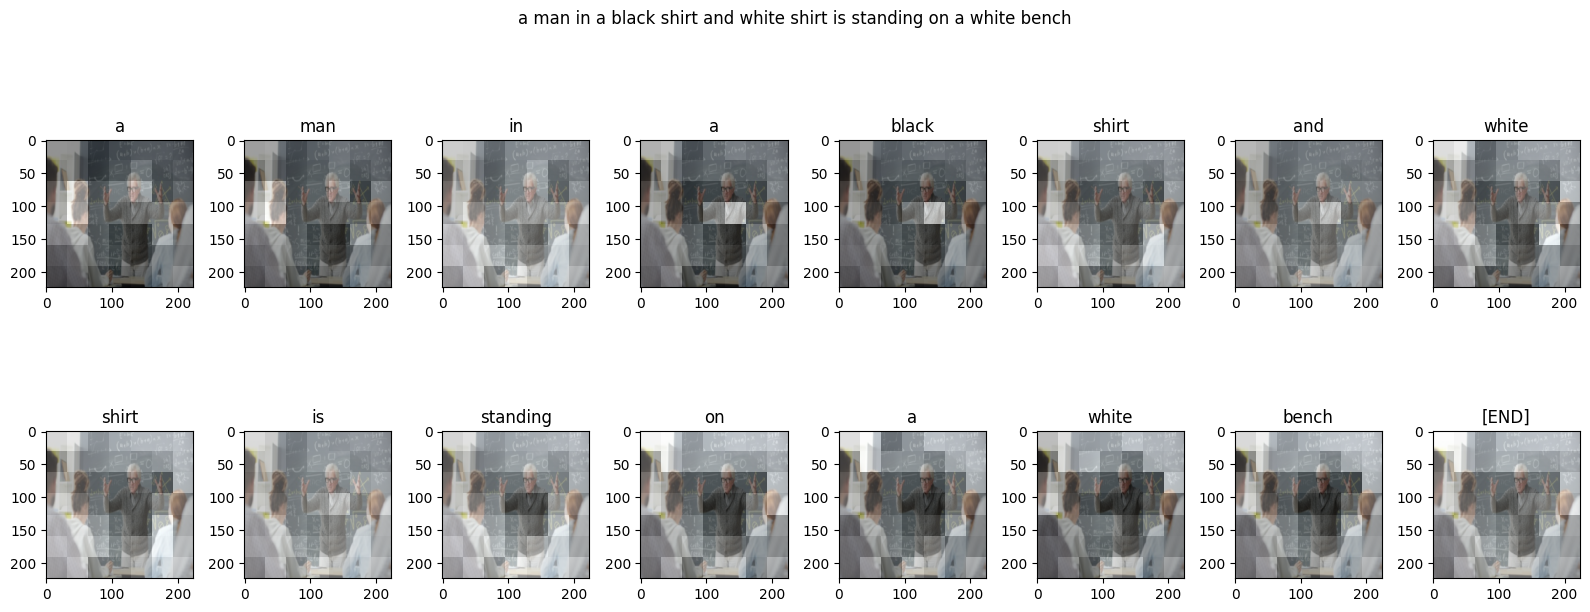

In [99]:
image_path = "/content/Profteachingexample.jpg"
image = load_image(image_path)

run_and_show_attention(model, image)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/486917990_72bd4069af.jpg', shape=(), dtype=string)


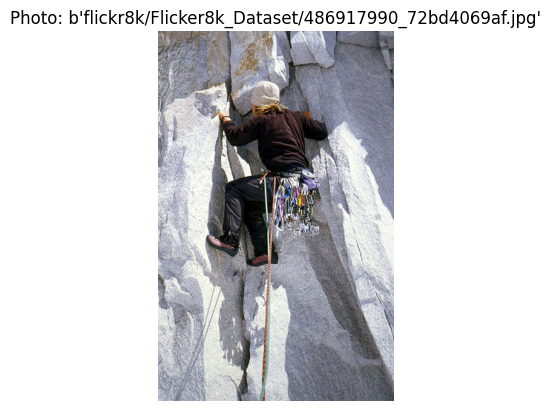

Captions:
 - A girl is climbing a rock wall .
 - A person climbs a steep mountain .
 - A person wearing a white hat climbs a rock .
 - A rock climber ascends .
 - Someone climbs a rocks .


tf.Tensor(b'flickr8k/Flicker8k_Dataset/2621415349_ef1a7e73be.jpg', shape=(), dtype=string)


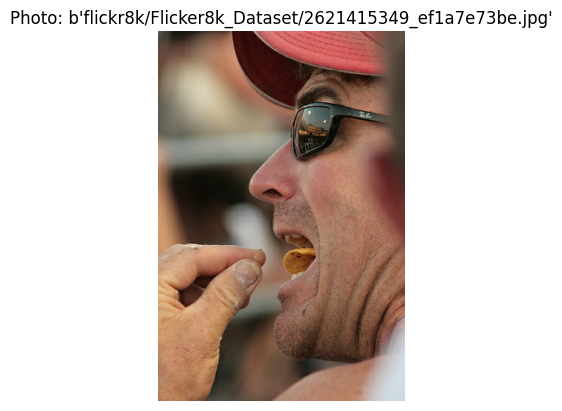

Captions:
 - A man in a red baseball cap eats a chip .
 - a man wearing a red hat has a potato chip in his mouth
 - A man wearing sunglasses and a red cap putting a chip in his mouth .
 - A man wearing sunglasses and a red hat is opening his mouth wide and eating a chip .
 - A man with sunglasses on puts a chip in his mouth .


tf.Tensor(b'flickr8k/Flicker8k_Dataset/758921886_55a351dd67.jpg', shape=(), dtype=string)


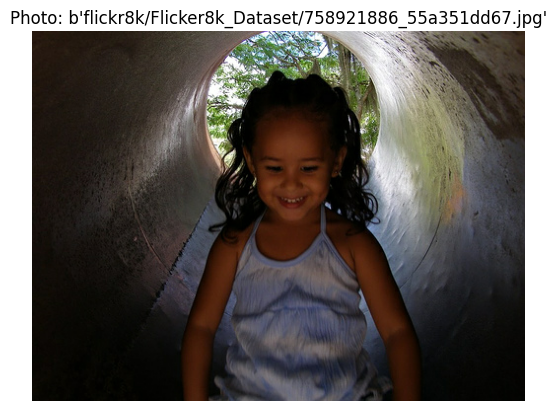

Captions:
 - A girl wearing a blue dress is sliding down a tube slide .
 - A little girl in a white top is inside a concrete tube .
 - A little girl is sliding down a tunnel smiling .
 - A little girl smiles as she slides down a tube on a sunny day .
 - A young girl in inside a tunnel .


tf.Tensor(b'flickr8k/Flicker8k_Dataset/3692593096_fbaea67476.jpg', shape=(), dtype=string)


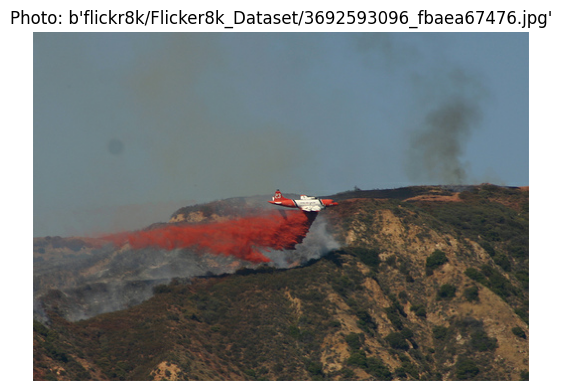

Captions:
 - Airplane emitting heavy red colored smoke .
 - An airplane is flying over the mountain trying to extinguish a fire .
 - A small plane is dropping a red chemical over the mountaintops .
 - Red spray is being ejected by an orange and white plane flying over the hilltops .
 - Small red airplane flies over mountaintop dropping red substance over fire .


tf.Tensor(b'flickr8k/Flicker8k_Dataset/3217187564_0ffd89dec1.jpg', shape=(), dtype=string)


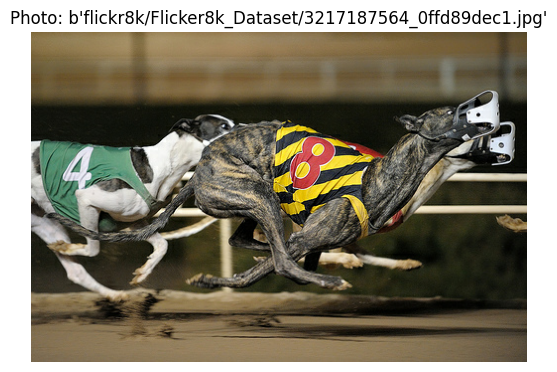

Captions:
 - A group of dogs racing .
 - A number eight racing dog is beating a number four racing dog slightly in a race .
 - Several dogs wearing muzzles are racing on a track .
 - There are three dogs wearing numbered jerseys running a race .
 - Three race dogs run to finish a race .




In [100]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt

# Set a seed for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
random.seed(seed_value)

_, test_dataset = flickr8k()

# Shuffle the test dataset
shuffled_test_dataset = test_dataset.shuffle(buffer_size=10000, seed=seed_value)

# Print and see some random photos from the test dataset with captions
num_photos_to_display = 5

for example in shuffled_test_dataset.take(num_photos_to_display):
    photo_path, captions_tensor = example[0], example[1]

    # Convert the captions tensor to a numpy array
    captions = [caption.numpy().decode('utf-8') for caption in captions_tensor]

    # Load and display the original image
    img = tf.io.read_file(photo_path)
    img = tf.image.decode_jpeg(img, channels=3)
    print(photo_path)

    plt.imshow(img)
    plt.title(f"Photo: {photo_path}")
    plt.axis('off')
    plt.show()

    print("Captions:")
    for caption in captions:
        print(f" - {caption}")
    print("\n")


a dog is running on a track


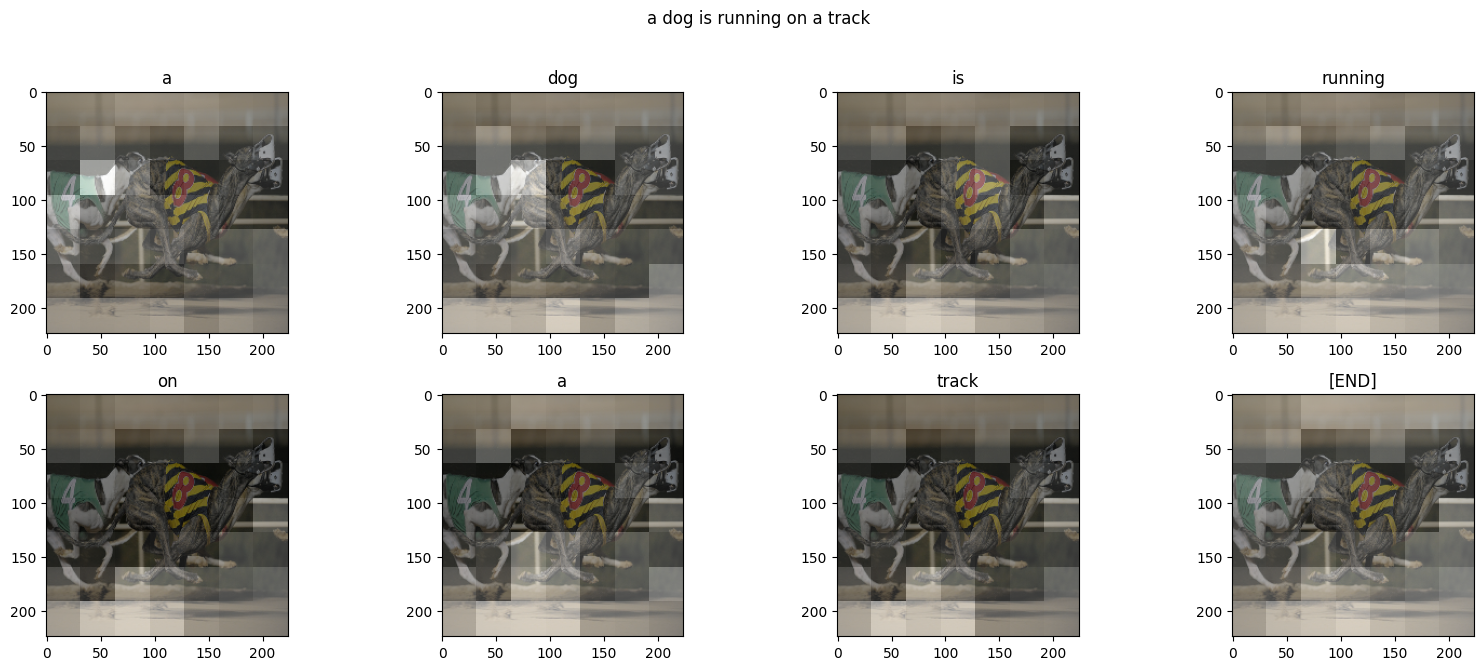

In [118]:
#The  image with attention plots

image_path = "/content/3217187564_0ffd89dec1.jpg"
image = load_image(image_path)

run_and_show_attention(model, image)



a person in a red shirt is climbing a rocky mountain


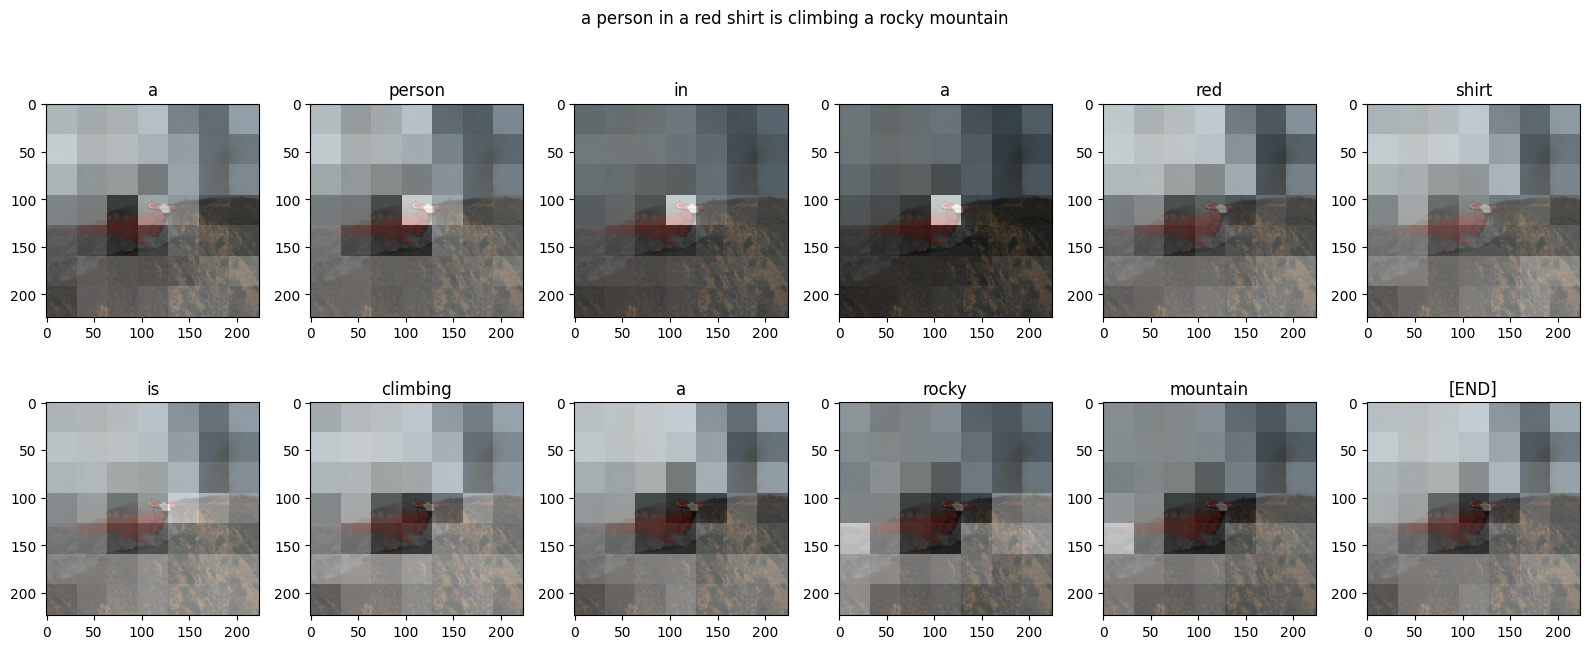

In [116]:
#The  image of a girl climbing
image_path = "/content/3692593096_fbaea67476.jpg"
image = load_image(image_path)

run_and_show_attention(model, image)



In [117]:
from nltk.translate.bleu_score import sentence_bleu

# Assuming references is a list of lists where each inner list contains the reference captions
references = [
    ['Airplane emitting heavy red colored smoke.'],
    ['An airplane is flying over the mountain trying to extinguish a fire.'],
    ['A small plane is dropping a red chemical over the mountaintops.'],
    ['Red spray is being ejected by an orange and white plane flying over the hilltops.'],
    ['Small red airplane flies over mountaintop dropping red substance over fire.']
]

# Assuming hypotheses is a list of generated captions
hypotheses = ['a person in a red shirt is climbing a rocky mountain']

# Tokenize the references and hypotheses
references = [[ref[0].split()] for ref in references]
hypotheses = [h.split() for h in hypotheses]

# Calculate BLEU score for each hypothesis-reference pair
individual_scores = [sentence_bleu(references[i], hypotheses[i]) for i in range(len(hypotheses))]

# Calculate the average BLEU score
average_bleu_score = sum(individual_scores) / len(individual_scores)

print("BLEU Score:", average_bleu_score)
print("BLEU individual_scores:", individual_scores)


BLEU Score: 1.0003688322288243e-231
BLEU individual_scores: [1.0003688322288243e-231]


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


a man is climbing a rock wall


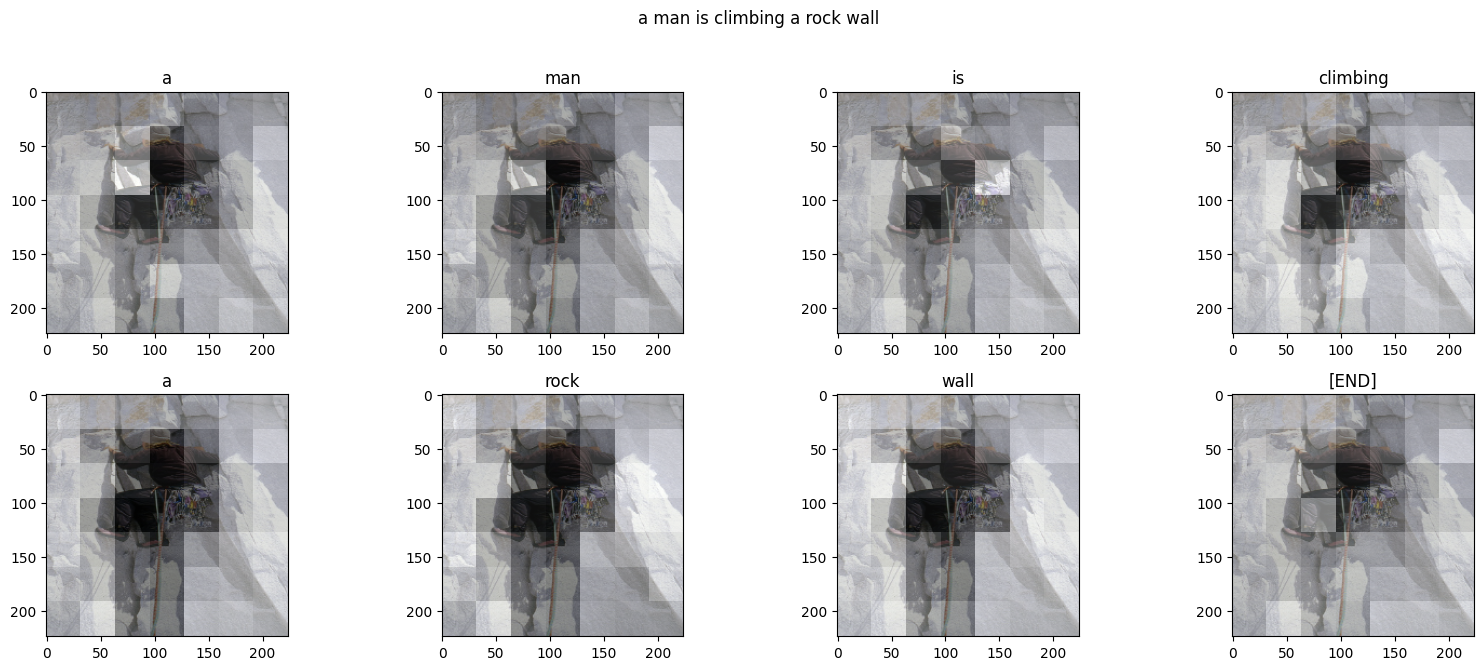

In [101]:
#The first image
image_path = "/content/486917990_72bd4069af.jpg"
image = load_image(image_path)

run_and_show_attention(model, image)



In [109]:
from nltk.translate.bleu_score import sentence_bleu

# Assuming references is a list of lists where each inner list contains the reference captions
references = [
    ['A girl is climbing a rock wall .'],
    ['A person climbs a steep mountain .'],
    ['A person wearing a white hat climbs a rock .'],
    ['A rock climber ascends .'],
    ['Someone climbs a rocks .']
]

# Assuming hypotheses is a list of generated captions
hypotheses = ['a man is climbing a rock wall']

# Tokenize the references and hypotheses
references = [[ref[0].split()] for ref in references]
hypotheses = [h.split() for h in hypotheses]

# Calculate BLEU score for each hypothesis-reference pair
individual_scores = [sentence_bleu(references[i], hypotheses[i]) for i in range(len(hypotheses))]

# Calculate the average BLEU score
average_bleu_score = sum(individual_scores) / len(individual_scores)

print("BLEU Score:", average_bleu_score)


BLEU Score: 0.5329462628216854
